## Unequal Game solution with CCEM method

In [0]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

# Calculating optimal guaranteed results

Let's find guaranteed results


Definitions

\begin{gather*}
\Gamma^u = \min_{u(\cdot)}\max_{v(\cdot)} \gamma(u,\, v), \quad 
\Gamma^v = \max_{v(\cdot)}\min_{u(\cdot)} \gamma(u,\, v), \\
\tilde{\Gamma}^u = \min_{u(\cdot,\, \cdot)}\max_{v(\cdot,\, \cdot)} \gamma(u, v), \quad 
\tilde{\Gamma}^v = \max_{v(\cdot,\, \cdot)}\min_{u(\cdot,\, \cdot)} \gamma(u, v), \\\\
\Gamma^v \leqslant \tilde{\Gamma}^v \leqslant  \tilde{\Gamma}^v \leqslant \Gamma^u.
\end{gather*}

Our differential game model

\begin{gather*}
\begin{cases}
\dot{x} = u(t,\,x) - v(t,\,x), \quad t \in [0, 2],\\
x(0) = 1, \\
|u| \leqslant 2, \quad |v| \leqslant 1.
\end{cases}, \\ \\
\gamma(u,\, v) = x^2(2) = \left(1 + \int\limits_0^2 u(t, x)\,dt - \int\limits_0^2 v(t, x)\,dt \right)^2 = (1 +U(x) + V(x))^2, \\|U| \leqslant 4, \quad |V| \leqslant 2, \\ \\
\Gamma^u = 4, \quad \Gamma^v = \tilde{\Gamma}^v = \tilde{\Gamma}^v = 0.
\end{gather*}

Compute $\Gamma^u$

\begin{gather*}
\max_V \gamma(U,\, V) = \max\left\{\gamma(U,\, 2),\, \gamma(U,\, -2)\right\}, \\ \\
\gamma(U, 2) - \gamma(U, -2) = -8(1+U).
\end{gather*}

Case 1:
\begin{gather*}
\max_V \gamma(U,\, V) = \gamma(U,\, 2) \; \Longrightarrow \; U \leqslant -1 \; \Longrightarrow \; \Gamma^u = \min_U \gamma(U\,2) = \gamma(-1, 2) = 4.
\end{gather*}

Case 2:
\begin{gather*}
\max_V \gamma(U,\, V) = \gamma(U,\, -2) \; \Longrightarrow \; U \geqslant -1 \; \Longrightarrow \; \Gamma^u = \min_U \gamma(U\,-2) = \gamma(-1, -2) = 4.
\end{gather*}


Compute $\Gamma^v$

\begin{gather*}
\frac{\partial}{\partial U} \gamma(U,\,V) = 2(1 + U - V) = 0 \;\Longrightarrow\; U = V - 1 \Longrightarrow\; \Gamma^v = \max_{V}\gamma(V-1,\,V) = 0
\end{gather*}

Compute $\tilde{\Gamma}^u$

\begin{gather*}
\forall U, V \quad \tilde{\Gamma}^u \geqslant 0, \\ \\
U(x) = - 4 \cdot \text{sign}(x) \;\Longrightarrow\; \gamma(U,\, V) = \max_{V}(1 - 4 \cdot \text{sign}(x) - V(x))^2
\end{gather*}

Compute $\tilde{\Gamma}^v$

\begin{gather*}
0 = \Gamma^v \leqslant \tilde{\Gamma}^v \leqslant \tilde{\Gamma}^u = 0 \; \Longrightarrow \; \tilde{\Gamma}^v = 0.
\end{gather*}

# Code implementation

## Implement environment

In [0]:
class UnequalGame:

    def __init__(self, initial_x=1, dt=0.005, terminal_time=2, u_action_max=2, v_action_max=1):
        self.u_action_max = u_action_max
        self.v_action_max = v_action_max
        self.terminal_time = terminal_time
        self.dt = dt
        self.initial_x = initial_x
        self.state = self.reset()

    def reset(self):
        self.state = np.array([0, self.initial_x])
        return self.state

    def step(self, u_action, v_action):
        t, x = self.state
        x = x + (u_action - v_action) * self.dt
        t += self.dt
        self.state = np.array([t, x])

        reward = 0
        done = False
        if t >= self.terminal_time:
            reward = x ** 2
            done = True

        return self.state, reward, done, None


## Implement agent

In [0]:
class Network(torch.nn.Module):

    def __init__(self, input_shape, output_shape):
        super().__init__()
        self.linear_1 = torch.nn.Linear(input_shape[0], 50)
        self.linear_2 = torch.nn.Linear(50, 30)
        self.linear_3 = torch.nn.Linear(30, output_shape[0])
        self.relu = torch.nn.ReLU()
        self.tang = torch.nn.Tanh()

    def forward(self, input_):
        hidden = self.relu(self.linear_1(input_))
        hidden = self.relu(self.linear_2(hidden))
        output = self.tang(self.linear_3(hidden))
        return output


class CCEMAgent(torch.nn.Module):

    def __init__(self, state_shape, action_shape, action_max, reward_param=1, percentile_param=70, noise_decrease=0.98,
                 tau=1e-2, learning_rate=1e-2, n_learning_per_fit=16):
        super().__init__()
        self.action_max = np.abs(action_max)
        self.reward_param = reward_param  # equal to 1 if agent wants to maximize reward otherwise -1
        self.percentile_param = percentile_param
        self.noise_decrease = noise_decrease
        self.noise_threshold = 1
        self.min_noise_threshold = 0.1
        self.tau = tau
        self.n_learning_per_fit = n_learning_per_fit
        self.network = Network(state_shape, action_shape)
        self.optimizer = torch.optim.Adam(params=self.network.parameters(), lr=learning_rate)

    def get_action(self, state, test=False):
        state = torch.FloatTensor(state)
        predicted_action = self.network(state).detach().numpy() * self.action_max
        if not test:
            noise = self.noise_threshold * np.random.uniform(low=-self.action_max, high=self.action_max)
            predicted_action = np.clip(predicted_action + noise, -self.action_max, self.action_max)
        return predicted_action

    def get_elite_states_and_actions(self, sessions):
        """
          Select sessions with the most or least reward
          by percentile
        """
        total_rewards = [session['total_reward'] for session in sessions]
        reward_threshold = np.percentile(total_rewards, self.percentile_param)

        elite_states = []
        elite_actions = []
        for session in sessions:
            if self.reward_param * (session['total_reward'] - reward_threshold) > 0:
                elite_states.extend(session['states'])
                elite_actions.extend(session[f'{self}actions'])

        return torch.FloatTensor(elite_states), torch.FloatTensor(elite_actions)

    def learn_network(self, loss):
        self.optimizer.zero_grad()
        old_network = deepcopy(self.network)
        loss.backward()
        self.optimizer.step()

        for new_parameter, old_parameter in zip(self.network.parameters(), old_network.parameters()):
            new_parameter.data.copy_(self.tau * new_parameter + (1 - self.tau) * old_parameter)

        return None

    def fit(self, sessions):
        elite_states, elite_actions = self.get_elite_states_and_actions(sessions)

        for _ in range(self.n_learning_per_fit):
            predicted_action = self.network(elite_states) * self.action_max
            loss = torch.mean((predicted_action - elite_actions) ** 2)
            self.learn_network(loss)

        if self.noise_threshold > self.min_noise_threshold:
            self.noise_threshold *= self.noise_decrease

        return None

    def __str__(self):
        return 'u_' if self.reward_param == -1 else 'v_'


## Generate sessions

In [0]:
def generate_session(u_agent, v_agent, env, test=False):
    """
    Generate session on environment with agent
    """
    states = []
    u_actions = []
    v_actions = []
    total_reward = 0
    done = False
    state = env.reset()
    while not done:
        u_action = u_agent.get_action(state, test=test)
        v_action = v_agent.get_action(state)
        actions = (u_action[0], v_action[0]) if str(u_agent) == 'u_' else (v_action[0], u_action[0])
        next_state, reward, done, _ = env.step(*actions)
        states.append(state)
        u_actions.append(u_action)
        v_actions.append(v_action)
        total_reward += reward
        state = next_state

    return {'states': states, \
            f'{u_agent}actions': u_actions, \
            f'{v_agent}actions': v_actions, \
            'total_reward': total_reward}


## Fit one epoch

In [0]:
def fit_epoch(u_agent, v_agent, env, n_sessions, test):
    sessions = [generate_session(u_agent, v_agent, env, test=test) for _ in range(n_sessions)]
    mean_reward = np.mean([session['total_reward'] for session in sessions])
    if not test:
        u_agent.fit(sessions)
    v_agent.fit(sessions)
    return mean_reward


## Test agents

In [0]:
def test_agent(u_agent, env, n_epochs, n_sessions, epsilon):
    v_agent = CCEMAgent((2,), (1,), percentile_param=70, action_max=env.v_action_max, reward_param=1)
    _, rewards = fit_agents(u_agent, v_agent, env, n_epochs, n_sessions, epsilon, test=True)
    return rewards

## Fit agents

In [0]:
def fit_agents(u_agent, v_agent, env, n_epochs, n_sessions,\
               epsilon, n_iter_debug=0, test=False):
    last_mean_reward = 0
    mean_rewards = []
    epoch = 0

    while epoch < n_epochs:

        if n_iter_debug and epoch and epoch % n_iter_debug == 0:
            print('\n{:-^50}\n'.format('TEST BEGIN'))
            test_agent(u_agent, env, n_epochs=20, n_sessions=n_sessions, epsilon=epsilon)
            print('\n{:-^50}\n'.format('TEST END'))
        
        mean_reward = fit_epoch(u_agent, v_agent, env, n_sessions, test)
        mean_rewards.append(mean_reward)
        print(f'epoch: {epoch}, mean reward: {mean_reward}')
        if np.abs(last_mean_reward - mean_reward) < epsilon:
            break
        last_mean_reward = mean_reward
        epoch += 1

        
    return u_agent, np.array(mean_rewards)


## Fit agents one by one

In [0]:
def fit_agents_one_by_one(u_agent, v_agent, env, n_epochs, n_sessions,\
                          n_iter_for_fit, epsilon, n_iter_debug=0):
    last_mean_reward = 0
    mean_rewards = []
    fit_agent = u_agent
    wait_agent = v_agent
    epoch = 0
    stop = False

    while not stop and epoch < n_epochs:

        for _ in range(n_iter_for_fit):
            if n_iter_debug and epoch and epoch % n_iter_debug == 0:
                print('\n{:-^50}\n'.format('TEST BEGIN'))
                test_agent(u_agent, env, n_epochs=20, n_sessions=n_sessions, epsilon=epsilon)
                print('\n{:-^50}\n'.format('TEST END'))

            mean_reward = fit_epoch(wait_agent, fit_agent, env, n_sessions, test=True)
            mean_rewards.append(mean_reward)
            print(f'epoch: {epoch}, current agent: {fit_agent}, mean reward: {mean_reward}')
            if np.abs(last_mean_reward - mean_reward) < epsilon:
                stop = True
                break
            last_mean_reward = mean_reward
            epoch += 1
            if epoch >= n_epochs:
                break

        print('\n')
        wait_agent, fit_agent = fit_agent, wait_agent

    return u_agent, np.array(mean_rewards)


## Fit random agent pairs

In [0]:
def fit_random_agent_pairs(u_agents, v_agents, env, n_pairs, n_epochs, n_sessions, n_iter_debug=0):
    u_agents_mean_rewards = [[] for _ in range(len(u_agents))]

    for _ in range(n_pairs):
        u_agent_idx = np.random.choice(len(u_agents))
        v_agent_idx = np.random.choice(len(v_agents))
        print('\n{:-^50}\n'.format(f'U_AGENT_{u_agent_idx} VS V_AGENT_{v_agent_idx}'))
        _, mean_rewards = fit_agents(u_agents[u_agent_idx], v_agents[v_agent_idx],
                                     env=env, n_epochs=n_epochs, n_sessions=n_sessions,
                                     epsilon=-1, n_iter_debug=n_iter_debug)
        print('\n{:-^50}\n'.format(''))
        u_agents_mean_rewards[u_agent_idx].append(mean_rewards.min())

    best_u_agent_idx = np.argmin(np.min(lst) if lst else float('inf') for lst in u_agents_mean_rewards)
    print(f'\nBest agent is {best_u_agent_idx}, its best reward is {np.min(u_agents_mean_rewards[best_u_agent_idx])}\n')
    return u_agents[best_u_agent_idx], u_agents_mean_rewards
    

## Plot mean rewards by epochs

In [0]:
def plot_mean_rewards(mean_rewards, method_name):
    _, ax = plt.subplots(figsize=(10, 8))
    ax.plot(range(len(mean_rewards)), mean_rewards, '--')
    ax.set_xlabel('epoch')
    ax.set_ylabel('Mean reward')
    ax.set_title(f'Mean rewards for {method_name} over epochs')
    plt.show()  

# Fitting

## Deafualt fit

In [0]:
env = UnequalGame()
u_agent = CCEMAgent((2,), (1,), percentile_param=30, action_max=env.u_action_max, reward_param=-1)
v_agent = CCEMAgent((2,), (1,), percentile_param=70, action_max=env.v_action_max, reward_param=1)

In [0]:
u_fit_agent, mean_rewards = fit_agents(u_agent, v_agent, env, n_epochs=101, n_sessions=100, epsilon=1e-6, n_iter_debug=50)

epoch: 0, mean reward: 1.3773243197560843
epoch: 1, mean reward: 1.2849220297923083
epoch: 2, mean reward: 1.1776507786345252
epoch: 3, mean reward: 1.0594609653392284
epoch: 4, mean reward: 0.9349823134704391
epoch: 5, mean reward: 0.8492211485084661
epoch: 6, mean reward: 0.7407841572648346
epoch: 7, mean reward: 0.6469161470111148
epoch: 8, mean reward: 0.5104650559918649
epoch: 9, mean reward: 0.42697672565390443
epoch: 10, mean reward: 0.3406296869713519
epoch: 11, mean reward: 0.2848880261093028
epoch: 12, mean reward: 0.23680522576171867
epoch: 13, mean reward: 0.18388487993362304
epoch: 14, mean reward: 0.14299283117802505
epoch: 15, mean reward: 0.10584941179520252
epoch: 16, mean reward: 0.06968883015453446
epoch: 17, mean reward: 0.04056886945767383
epoch: 18, mean reward: 0.022133273573165857
epoch: 19, mean reward: 0.012398481921391527
epoch: 20, mean reward: 0.0060429898070711785
epoch: 21, mean reward: 0.002909253841796586
epoch: 22, mean reward: 0.0029399799736055192
ep

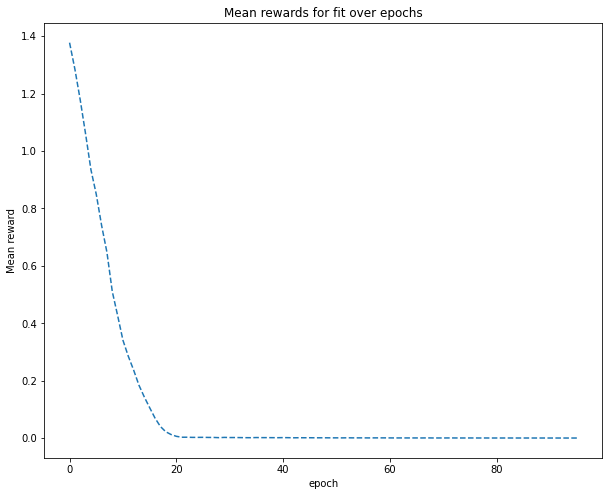

In [0]:
plot_mean_rewards(mean_rewards, method_name='fit')

## Fit one by one

In [0]:
u_agent_one_by_one = CCEMAgent((2,), (1,), percentile_param=30, action_max=env.u_action_max, reward_param=-1)
v_agent_one_by_one = CCEMAgent((2,), (1,), percentile_param=70, action_max=env.v_action_max, reward_param=1)

In [35]:
u_fit_agent_one_by_one, mean_rewards_one_by_one =\
fit_agents_one_by_one(u_agent_one_by_one, v_agent_one_by_one, env, \
                       n_epochs=301, n_sessions=100, n_iter_for_fit=20, epsilon=-1, n_iter_debug=50)

epoch: 0, current agent: u_, mean reward: 0.6217259537261607
epoch: 1, current agent: u_, mean reward: 0.4602930440226248
epoch: 2, current agent: u_, mean reward: 0.29830563390050197
epoch: 3, current agent: u_, mean reward: 0.1778145196453188
epoch: 4, current agent: u_, mean reward: 0.09616327476300851
epoch: 5, current agent: u_, mean reward: 0.033047069052012934
epoch: 6, current agent: u_, mean reward: 0.016104570400324945
epoch: 7, current agent: u_, mean reward: 0.010773317676115288
epoch: 8, current agent: u_, mean reward: 0.011016364589016251
epoch: 9, current agent: u_, mean reward: 0.010102929985774249
epoch: 10, current agent: u_, mean reward: 0.007221379664705387
epoch: 11, current agent: u_, mean reward: 0.006578172394736825
epoch: 12, current agent: u_, mean reward: 0.007500003274676279
epoch: 13, current agent: u_, mean reward: 0.007039169666631206
epoch: 14, current agent: u_, mean reward: 0.006497921376231089
epoch: 15, current agent: u_, mean reward: 0.0053482894561

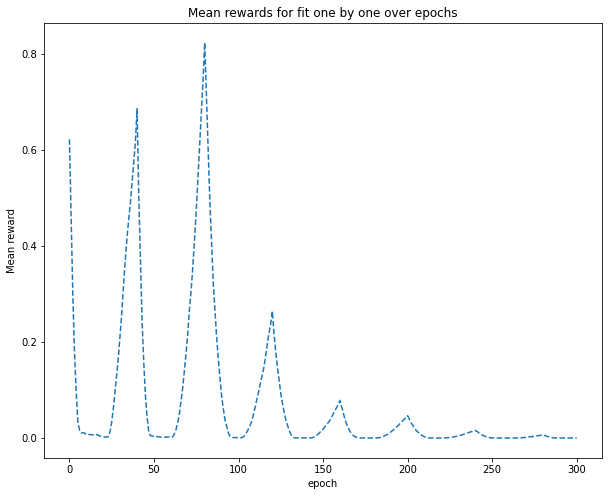

In [36]:
plot_mean_rewards(mean_rewards_one_by_one, method_name='fit one by one')

## Fit random pairs

In [0]:
u_agents = [CCEMAgent((2,), (1,), percentile_param=30, action_max=env.u_action_max, reward_param=-1)\
            for _ in range(5)]
v_agents = [CCEMAgent((2,), (1,), percentile_param=70, action_max=env.v_action_max, reward_param=1)\
            for _ in range(5)]

In [42]:
u_fit_random_agent, mean_rewards_random = fit_random_agent_pairs(u_agents, v_agents, env,\
                                                                 n_pairs=20, n_epochs=20, n_sessions=100, n_iter_debug=0)


--------------U_AGENT_1 VS V_AGENT_0--------------

epoch: 0, mean reward: 5.395407871794628
epoch: 1, mean reward: 4.751720269254389
epoch: 2, mean reward: 4.177863807161329
epoch: 3, mean reward: 3.6647508906614776
epoch: 4, mean reward: 3.2472004795479665
epoch: 5, mean reward: 2.8803140657726307
epoch: 6, mean reward: 2.445676608189651
epoch: 7, mean reward: 2.141482605631035
epoch: 8, mean reward: 1.915194668136202
epoch: 9, mean reward: 1.6608854641660273
epoch: 10, mean reward: 1.4252524010206673
epoch: 11, mean reward: 1.2236997366117084
epoch: 12, mean reward: 0.9971516280470648
epoch: 13, mean reward: 0.8818782631069553
epoch: 14, mean reward: 0.7542736971299362
epoch: 15, mean reward: 0.61632730742326
epoch: 16, mean reward: 0.5326956100507938
epoch: 17, mean reward: 0.4187103591283084
epoch: 18, mean reward: 0.3437787655984964
epoch: 19, mean reward: 0.2726083602565835

--------------------------------------------------


--------------U_AGENT_0 VS V_AGENT_0--------------


# Testing

## Test default u_agent

In [0]:
test_rewards = test_agent(u_fit_agent, env, n_epochs=50, n_sessions=100, epsilon=-1)

epoch: 0, mean reward: 0.003540376363573217
epoch: 1, mean reward: 0.003854413225272795


KeyboardInterrupt: ignored

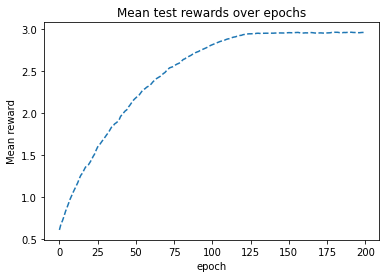

In [0]:
plot_mean_rewards(test_rewards, method_name='test')

## Test u_agent_one_by_one

In [0]:
test_rewards_one_by_one = test_agent(u_fit_agent_one_by_one, env, n_epochs=50, n_sessions=100, epsilon=1e-6)

epoch: 0, mean reward: 1.8904017970650102
epoch: 1, mean reward: 2.0885442948180923


KeyboardInterrupt: ignored

In [0]:
plot_mean_rewards(test_rewards_one_by_one, method_name='test one by one')

## Test u_agent_random

In [43]:
test_rewards_random = test_agent(u_fit_random_agent, env, n_epochs=50, n_sessions=100, epsilon=1e-6)

epoch: 0, mean reward: 1.528297492605777
epoch: 1, mean reward: 1.6296178719130816
epoch: 2, mean reward: 1.7326942654073048
epoch: 3, mean reward: 1.8258626555106798
epoch: 4, mean reward: 1.898074342931412
epoch: 5, mean reward: 1.9778876034830262
epoch: 6, mean reward: 2.0721495362563886
epoch: 7, mean reward: 2.165068378471574
epoch: 8, mean reward: 2.248747824301549
epoch: 9, mean reward: 2.333047099675407
epoch: 10, mean reward: 2.420131887761807
epoch: 11, mean reward: 2.4838559782290517
epoch: 12, mean reward: 2.5846076565757308
epoch: 13, mean reward: 2.671670035161762
epoch: 14, mean reward: 2.763282630870746
epoch: 15, mean reward: 2.840075122924543
epoch: 16, mean reward: 2.923463620247993
epoch: 17, mean reward: 2.996802678408969
epoch: 18, mean reward: 3.0956656598813326
epoch: 19, mean reward: 3.178412443594399
epoch: 20, mean reward: 3.2539623248948546
epoch: 21, mean reward: 3.287516654584037
epoch: 22, mean reward: 3.3811910365146924
epoch: 23, mean reward: 3.43992520

In [0]:
plot_mean_rewards(test_rewards_random, method_name='test random pairs')